In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [38]:
df = pd.read_csv("data.csv")
# Read in the data
data = pd.read_csv('data.csv', index_col='Date', parse_dates=True)

# Set the frequency of the index to monthly
data.index.freq = 'M'

In [39]:
df['ds'] = pd.date_range(start='1992-01-01', periods=288, freq='M')
df.set_index('ds')['TouristNumber']
df = df.set_index('ds')
df.drop('Date', axis=1, inplace=True) 
df

,TouristNumber
ds,
1992-01-31,8414
1992-02-29,9767
1992-03-31,13805
1992-04-30,12987
1992-05-31,32190
...,...
2015-08-31,82593
2015-09-30,53472
2015-10-31,30361


<AxesSubplot:xlabel='Date'>

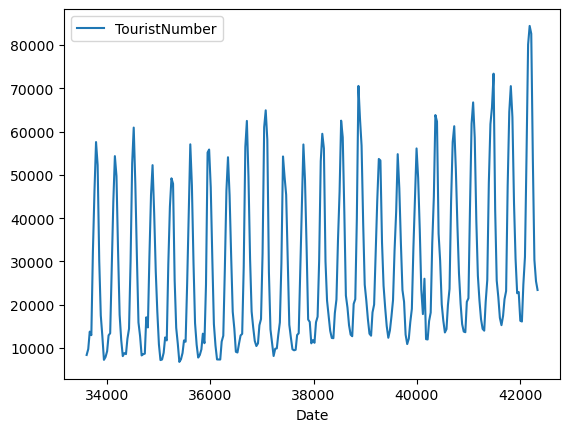

In [4]:
data.plot()

/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


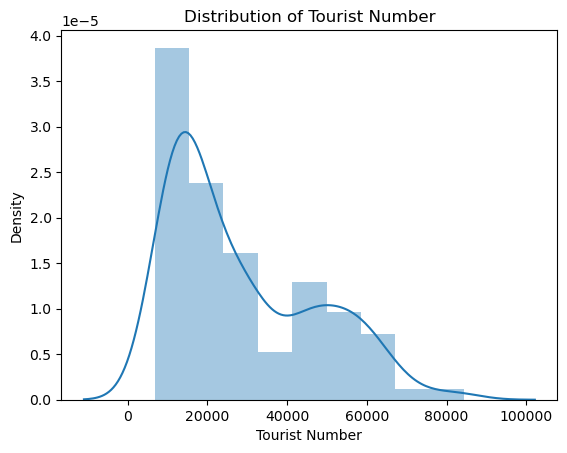

In [5]:
# create a distribution plot using seaborn
sns.distplot(data['TouristNumber'])

# set the title and axis labels
plt.title('Distribution of Tourist Number')
plt.xlabel('Tourist Number')

# display the plot
plt.show()

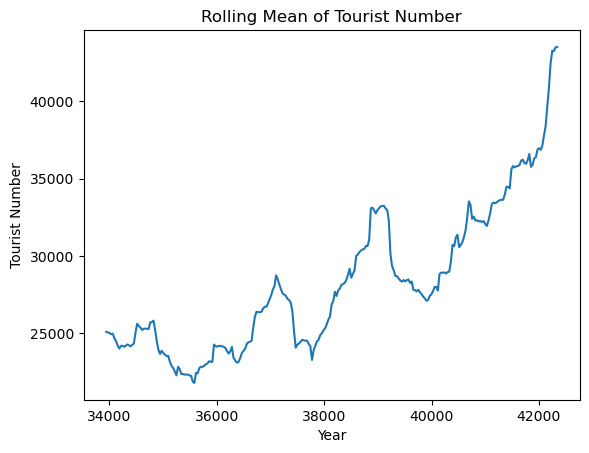

In [6]:
# calculate the rolling mean with a window of 12 months
rolling_mean = data.rolling(window=12).mean()

# create a line plot of the rolling mean
plt.plot(data.index, rolling_mean['TouristNumber'])

# set the title and axis labels
plt.title('Rolling Mean of Tourist Number')
plt.xlabel('Year')
plt.ylabel('Tourist Number')

# display the plot
plt.show()

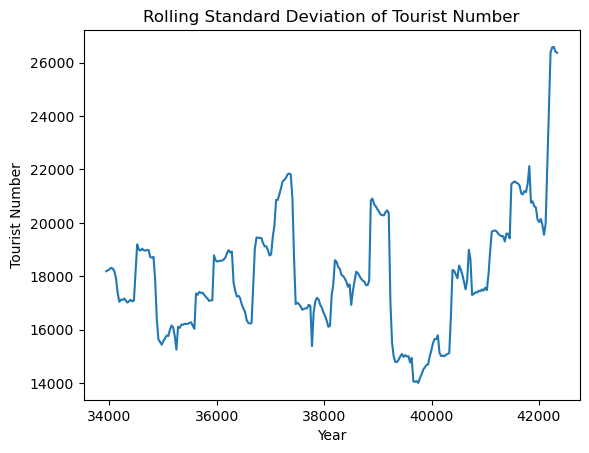

In [7]:
# calculate the rolling standard deviation with a window of 12 months
rolling_std = data.rolling(window=12).std()

# create a line plot of the rolling standard deviation
plt.plot(data.index, rolling_std['TouristNumber'])

# set the title and axis labels
plt.title('Rolling Standard Deviation of Tourist Number')
plt.xlabel('Year')
plt.ylabel('Tourist Number')

# display the plot
plt.show()

In [8]:
# perform the ADF test on the 'TouristNumber' column
result = adfuller(df['TouristNumber'])

# print the test statistic and p-value
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Test Statistic: 1.2474703429336202
p-value: 0.9962979950836333


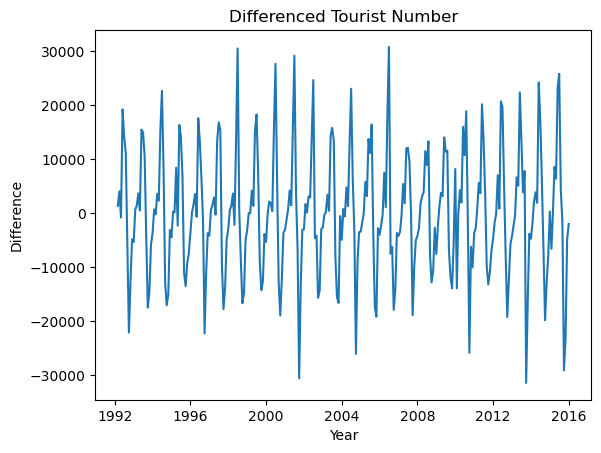

In [9]:
# take the first difference of the 'TouristNumber' column
diff = df['TouristNumber'].diff().dropna()

# plot the differenced data
plt.plot(diff)
plt.title('Differenced Tourist Number')
plt.xlabel('Year')
plt.ylabel('Difference')
plt.show()

In [10]:
# performing adfuller test again to see if the series is stationary or 
# not

# perform the ADF test on the differenced data
result = adfuller(diff)

# print the test statistic and p-value
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')


Test Statistic: -8.170180333920072
p-value: 8.665017597612557e-13


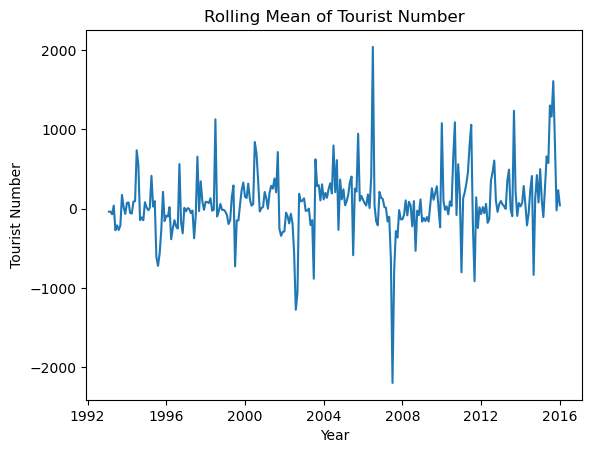

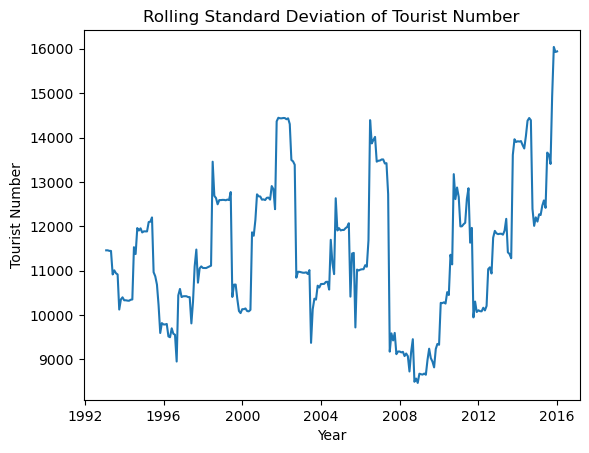

In [11]:
# calculate the rolling mean with a window of 12 months
rolling_mean = diff.rolling(window=12).mean()

# create a line plot of the rolling mean
plt.plot(diff.index, rolling_mean)

# set the title and axis labels
plt.title('Rolling Mean of Tourist Number')
plt.xlabel('Year')
plt.ylabel('Tourist Number')

# display the plot
plt.show()



# calculate the rolling standard deviation with a window of 12 months
rolling_std = diff.rolling(window=12).std()

# create a line plot of the rolling standard deviation
plt.plot(diff.index, rolling_std)

# set the title and axis labels
plt.title('Rolling Standard Deviation of Tourist Number')
plt.xlabel('Year')
plt.ylabel('Tourist Number')

# display the plot
plt.show()

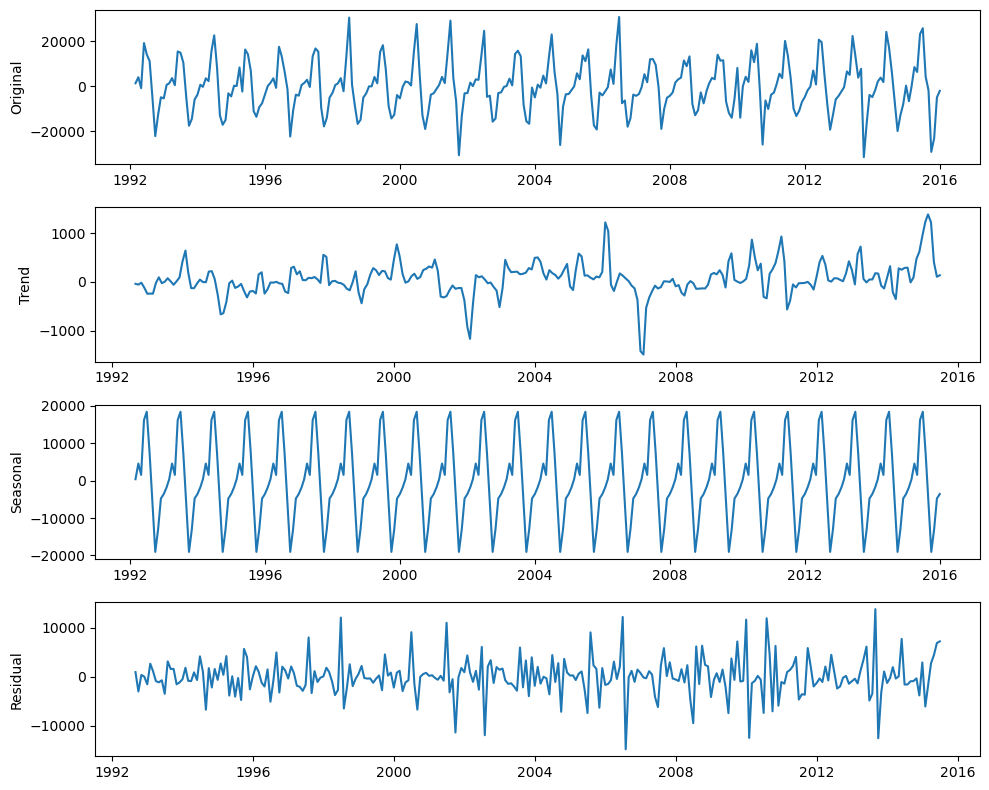

In [12]:
# (A) Additive

# apply the seasonal decomposition and obtain the components
decomposition = seasonal_decompose(diff, model='additive', period=12)

# extract the components from the decomposition object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot the original time series data and its components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(diff)
plt.ylabel('Original')

plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


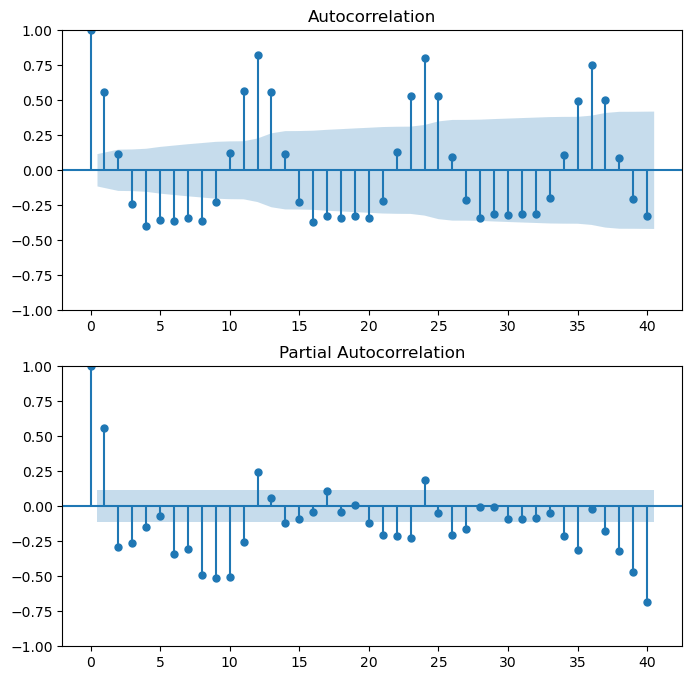

In [13]:
# 8. Plotting ACF, PCF for the differencing data


# Plot ACF and PACF of differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(diff, ax=ax1, lags=40)
plot_pacf(diff, ax=ax2, lags=40)
plt.show()

In [14]:
# Define the percentage of data to use for training
train_pct = 0.8

# Split the data into training and test sets
train_size = int(len(diff) * train_pct)
train, test = diff.iloc[:train_size], diff.iloc[train_size:]

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

Training set shape: (229,)
Test set shape: (58,)


In [15]:
# Define the p, d, and q values for the ARIMA model
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)


In [61]:
def evaluate_arima_model(X,y,arima_order):
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(y,predictions))
    return rmse

In [62]:
def evaluate_models(dataset,test,p_values,d_values,q_values):
    dataset = dataset.astype('float32')
    best_score,best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset,test,order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('Arima%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg,best_score))

In [16]:
df2= diff.to_frame()

In [17]:
# Define the percentage of data to use for training
train_pct = 0.8

# Split the data into training and test sets
train_size = int(len(df2) * train_pct)
train, test = df2.iloc[:train_size], df2.iloc[train_size:]

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

Training set shape: (229, 1)
Test set shape: (58, 1)


In [18]:
model = ARIMA(train, order=(19,1,2))
model_fit = model.fit()
print(model_fit.summary())

/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pratikhotchandani/opt/anaconda3

                               SARIMAX Results                                
Dep. Variable:          TouristNumber   No. Observations:                  229
Model:                ARIMA(19, 1, 2)   Log Likelihood               -2220.757
Date:                Mon, 13 Mar 2023   AIC                           4485.513
Time:                        21:53:32   BIC                           4560.959
Sample:                    02-29-1992   HQIC                          4515.953
                         - 02-28-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3331      0.313     -4.264      0.000      -1.946      -0.720
ar.L2         -0.8218      0.465     -1.766      0.077      -1.734       0.090
ar.L3         -0.7622      0.620     -1.230      0.2

/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='ds'>

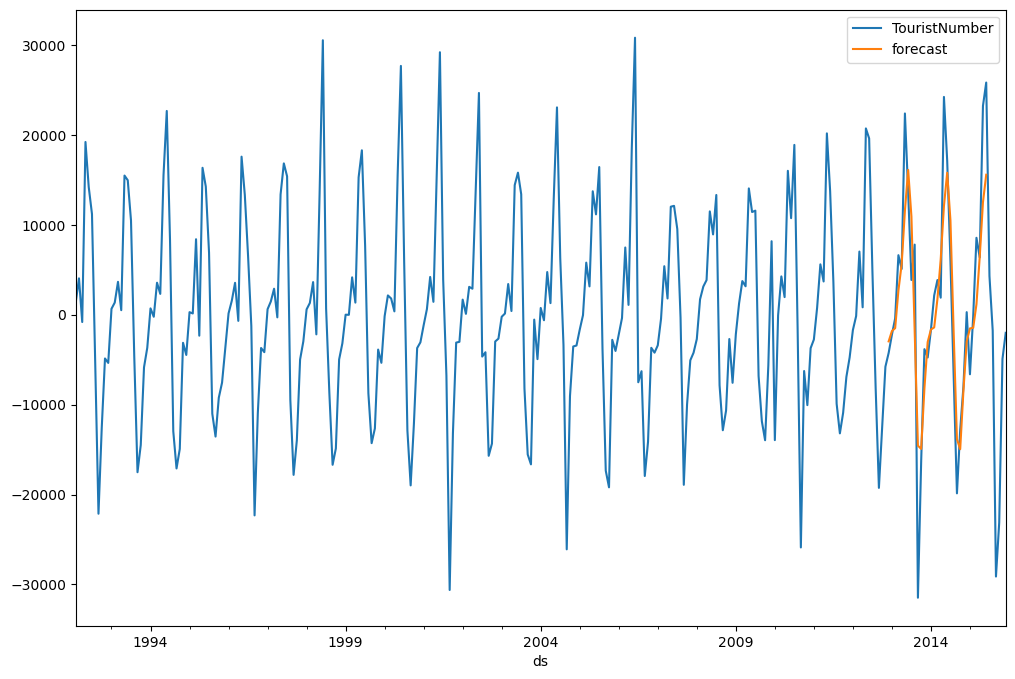

In [19]:
df2['forecast']=model_fit.predict(start=250,end=280,dynamic=True)
df2[['TouristNumber','forecast']].plot(figsize=(12,8))

In [ ]:
# Let's try differencing the data again

In [20]:
diff2 = df2['TouristNumber'].diff().dropna()

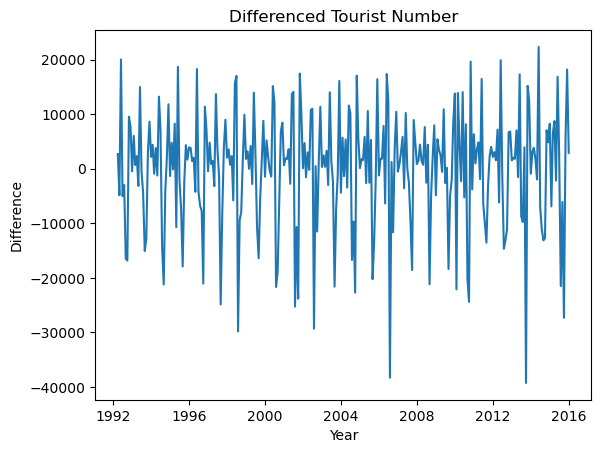

In [21]:
# plot the differenced data
plt.plot(diff2)
plt.title('Differenced Tourist Number')
plt.xlabel('Year')
plt.ylabel('Difference')
plt.show()

In [22]:
# perform the ADF test on the differenced data
result = adfuller(diff2)

# print the test statistic and p-value
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Test Statistic: -10.488521493261079
p-value: 1.1632889610270773e-18


In [23]:
df3= diff2.to_frame()

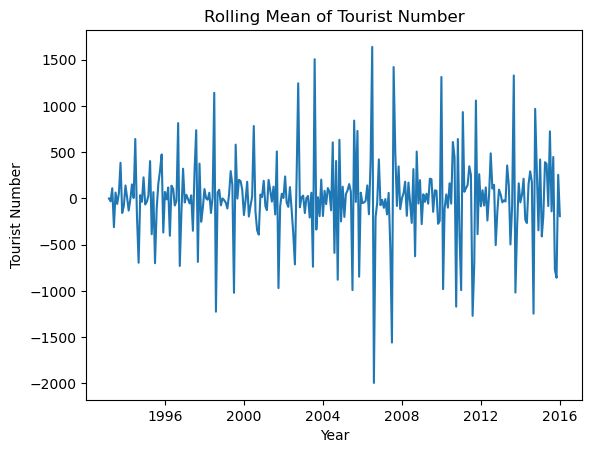

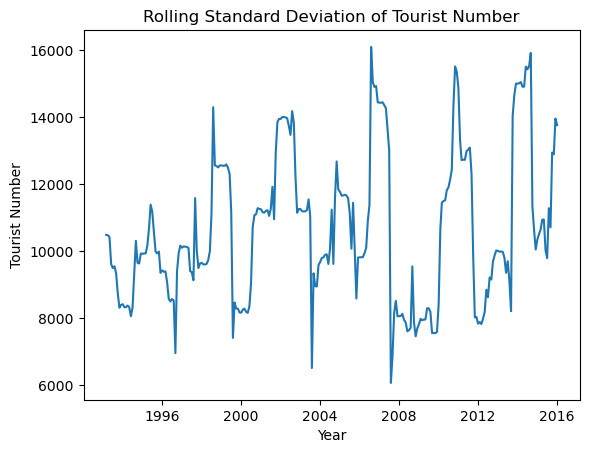

In [24]:
# calculate the rolling mean with a window of 12 months
rolling_mean = df3.rolling(window=12).mean()

# create a line plot of the rolling mean
plt.plot(df3.index, rolling_mean['TouristNumber'])

# set the title and axis labels
plt.title('Rolling Mean of Tourist Number')
plt.xlabel('Year')
plt.ylabel('Tourist Number')

# display the plot
plt.show()



# calculate the rolling standard deviation with a window of 12 months
rolling_std = df3.rolling(window=12).std()

# create a line plot of the rolling standard deviation
plt.plot(df3.index, rolling_std['TouristNumber'])

# set the title and axis labels
plt.title('Rolling Standard Deviation of Tourist Number')
plt.xlabel('Year')
plt.ylabel('Tourist Number')

# display the plot
plt.show()

In [25]:
# Define the percentage of data to use for training
train_pct = 0.8

# Split the data into training and test sets
train_size = int(len(df3) * train_pct)
train, test = df3.iloc[:train_size], df3.iloc[train_size:]

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

Training set shape: (228, 1)
Test set shape: (58, 1)


In [26]:
model = ARIMA(train, order=(19,2,2))
model_fit = model.fit()
print(model_fit.summary())

/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pratikhotchandani/opt/anaconda3

                               SARIMAX Results                                
Dep. Variable:          TouristNumber   No. Observations:                  228
Model:                ARIMA(19, 2, 2)   Log Likelihood               -2242.885
Date:                Mon, 13 Mar 2023   AIC                           4529.771
Time:                        21:53:57   BIC                           4605.022
Sample:                    03-31-1992   HQIC                          4560.139
                         - 02-28-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5575      0.176     -8.873      0.000      -1.902      -1.214
ar.L2         -2.1678      0.350     -6.194      0.000      -2.854      -1.482
ar.L3         -2.7749      0.563     -4.927      0.0

/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='ds'>

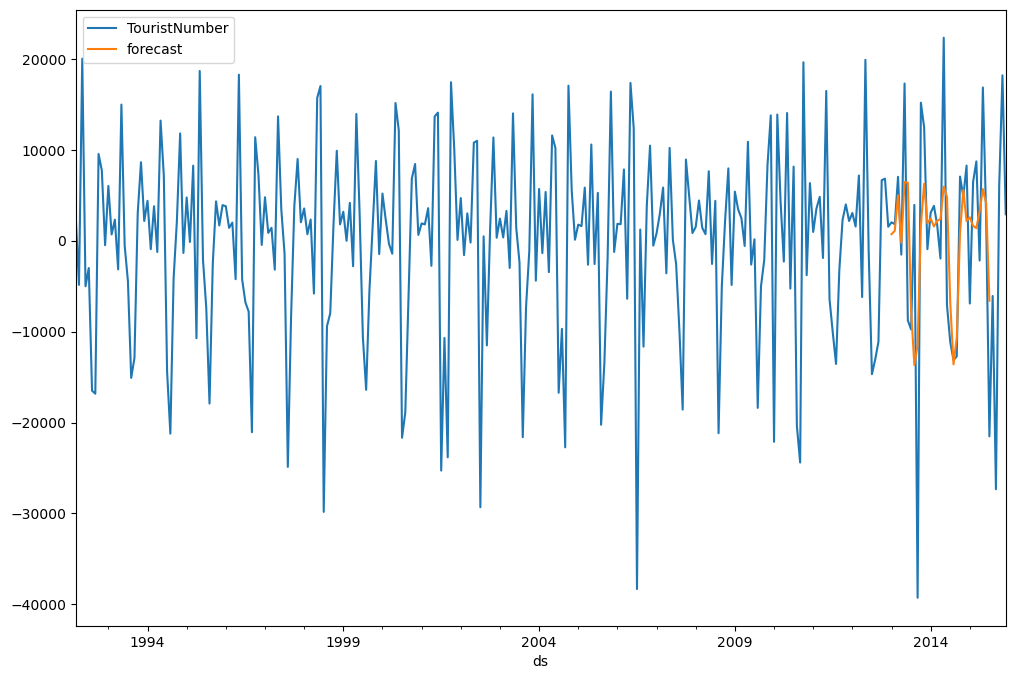

In [27]:
df3['forecast']=model_fit.predict(start=250,end=280,dynamic=True)
df3[['TouristNumber','forecast']].plot(figsize=(12,8))

In [28]:
# Now Let's create a SARIMA model

In [29]:
import statsmodels.api as sm


In [30]:
model=sm.tsa.statespace.SARIMAX(df3['TouristNumber'],order=(5, 2, 7), seasonal_order=(5, 2, 3, 12))
results=model.fit()

/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84812D+00    |proj g|=  1.60815D-01


 This problem is unconstrained.



At iterate    5    f=  9.71116D+00    |proj g|=  4.67749D-02

At iterate   10    f=  9.69548D+00    |proj g|=  2.84148D-02

At iterate   15    f=  9.68380D+00    |proj g|=  2.38087D-02

At iterate   20    f=  9.68125D+00    |proj g|=  6.49394D-03

At iterate   25    f=  9.68088D+00    |proj g|=  3.40453D-03

At iterate   30    f=  9.68047D+00    |proj g|=  1.17636D-02

At iterate   35    f=  9.68014D+00    |proj g|=  1.14685D-02

At iterate   40    f=  9.67971D+00    |proj g|=  4.48354D-03

At iterate   45    f=  9.67956D+00    |proj g|=  5.24036D-04


/Users/pratikhotchandani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.67949D+00    |proj g|=  1.19602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     56      1     0     0   1.196D-03   9.679D+00
  F =   9.6794937848052633     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [31]:
print(results.summary())

                                         SARIMAX Results                                          
Dep. Variable:                              TouristNumber   No. Observations:                  286
Model:             SARIMAX(5, 2, 7)x(5, 2, [1, 2, 3], 12)   Log Likelihood               -2768.335
Date:                                    Mon, 13 Mar 2023   AIC                           5578.670
Time:                                            21:58:56   BIC                           5653.445
Sample:                                        03-31-1992   HQIC                          5608.731
                                             - 12-31-2015                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.1014      3.224     -0.962      0

<AxesSubplot:xlabel='ds'>

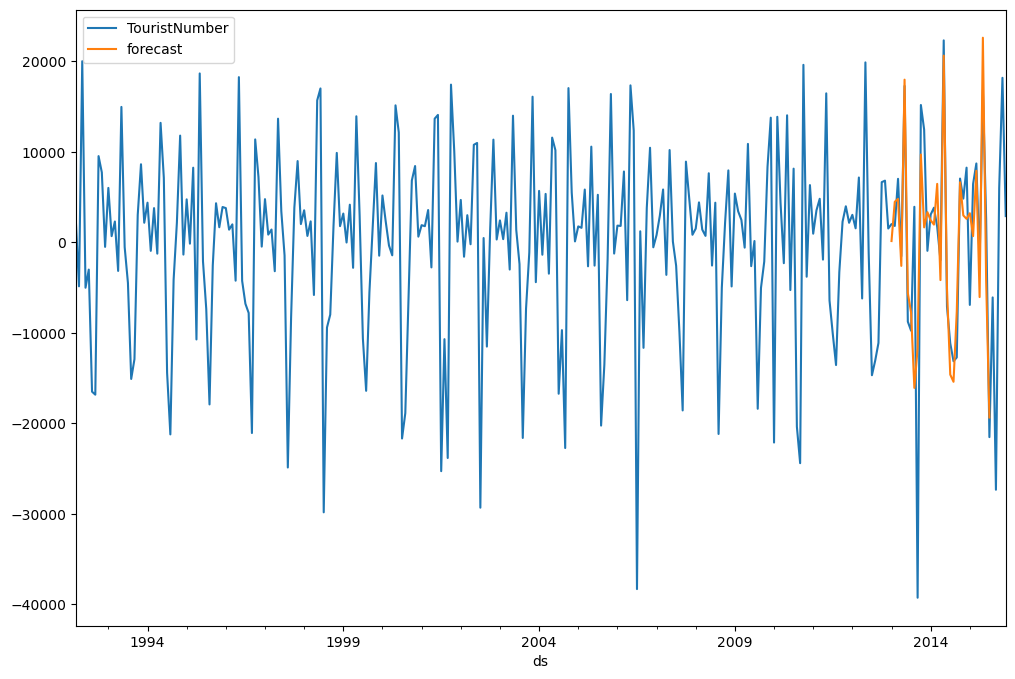

In [32]:
df3['forecast']=results.predict(start=250,end=280,dynamic=True)
df3[['TouristNumber','forecast']].plot(figsize=(12,8))

In [34]:
from pmdarima.arima.utils import ndiffs

In [41]:
ndiffs(df.TouristNumber, test = "adf")

0